In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/heartbeat/ptbdb_abnormal.csv
/kaggle/input/heartbeat/ptbdb_normal.csv
/kaggle/input/heartbeat/mitbih_test.csv
/kaggle/input/heartbeat/mitbih_train.csv


## 1. Explore Data

MIT-BIH Arrhythmia Dataset
Training samples: 87554
Test samples: 21892
Features per sample: 187

Feature range: [0.0000, 1.0000]

Class Distribution (Training):
  Class 0:  72471 samples (82.77%)
  Class 1:   2223 samples ( 2.54%)
  Class 2:   5788 samples ( 6.61%)
  Class 3:    641 samples ( 0.73%)
  Class 4:   6431 samples ( 7.35%)

Class Distribution (Test):
  Class 0:  18118 samples (82.76%)
  Class 1:    556 samples ( 2.54%)
  Class 2:   1448 samples ( 6.61%)
  Class 3:    162 samples ( 0.74%)
  Class 4:   1608 samples ( 7.35%)

Class Imbalance Ratio (Training):
  Class 0: 1:1.00
  Class 1: 1:32.60
  Class 2: 1:12.52
  Class 3: 1:113.06
  Class 4: 1:11.27


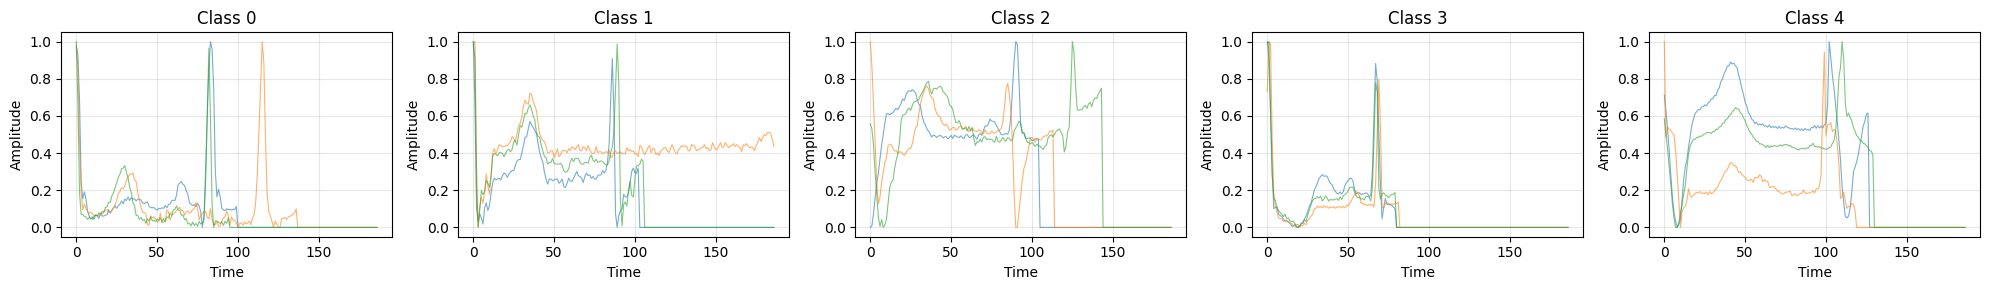


Data Quality Check:
  Missing values (train): 0
  Missing values (test): 0
  Duplicate samples (train): 0
  Duplicate samples (test): 0


In [2]:
import matplotlib.pyplot as plt
from collections import Counter

train = pd.read_csv('/kaggle/input/heartbeat/mitbih_train.csv', header=None)
test = pd.read_csv('/kaggle/input/heartbeat/mitbih_test.csv', header=None)

print("MIT-BIH Arrhythmia Dataset")
print("=" * 60)
print(f"Training samples: {len(train)}")
print(f"Test samples: {len(test)}")
print(f"Features per sample: {train.shape[1] - 1}")
print(f"\nFeature range: [{train.iloc[:, :-1].min().min():.4f}, {train.iloc[:, :-1].max().max():.4f}]")

print("\nClass Distribution (Training):")
train_labels = train.iloc[:, -1].values
class_counts = Counter(train_labels)
for cls in sorted(class_counts.keys()):
    count = class_counts[cls]
    pct = 100 * count / len(train)
    print(f"  Class {int(cls)}: {count:6d} samples ({pct:5.2f}%)")

print("\nClass Distribution (Test):")
test_labels = test.iloc[:, -1].values
test_counts = Counter(test_labels)
for cls in sorted(test_counts.keys()):
    count = test_counts[cls]
    pct = 100 * count / len(test)
    print(f"  Class {int(cls)}: {count:6d} samples ({pct:5.2f}%)")

print("\nClass Imbalance Ratio (Training):")
max_class = max(class_counts.values())
for cls in sorted(class_counts.keys()):
    ratio = max_class / class_counts[cls]
    print(f"  Class {int(cls)}: 1:{ratio:.2f}")

fig, axes = plt.subplots(1, 5, figsize=(20, 3))
for i in range(5):
    class_samples = train[train.iloc[:, -1] == i].iloc[:, :-1].values
    for j in range(min(3, len(class_samples))):
        axes[i].plot(class_samples[j], alpha=0.6, linewidth=0.8)
    axes[i].set_title(f'Class {i}')
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Amplitude')
    axes[i].grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('class_samples.png', dpi=100, bbox_inches='tight')
plt.show()

print("\nData Quality Check:")
print(f"  Missing values (train): {train.isnull().sum().sum()}")
print(f"  Missing values (test): {test.isnull().sum().sum()}")
print(f"  Duplicate samples (train): {train.duplicated().sum()}")
print(f"  Duplicate samples (test): {test.duplicated().sum()}")

## 2. Preprocessing data

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

train = pd.read_csv('/kaggle/input/heartbeat/mitbih_train.csv', header=None)
test = pd.read_csv('/kaggle/input/heartbeat/mitbih_test.csv', header=None)

X_train_full = train.iloc[:, :-1].values
y_train_full = train.iloc[:, -1].values.astype(int)
X_test = test.iloc[:, :-1].values
y_test = test.iloc[:, -1].values.astype(int)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.1, random_state=42, stratify=y_train_full
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("Preprocessing Summary")
print("=" * 60)
print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nFeature dimension: {X_train.shape[1]}")
print(f"\nStandardization applied:")
print(f"  Mean (train): {X_train_scaled.mean():.6f}")
print(f"  Std (train): {X_train_scaled.std():.6f}")

print("\nClass distribution (Training):")
unique, counts = np.unique(y_train, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"  Class {cls}: {count} samples")

print("\nClass distribution (Validation):")
unique, counts = np.unique(y_val, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"  Class {cls}: {count} samples")

print("\nClass distribution (Test):")
unique, counts = np.unique(y_test, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"  Class {cls}: {count} samples")

np.save('X_train_scaled.npy', X_train_scaled)
np.save('X_val_scaled.npy', X_val_scaled)
np.save('X_test_scaled.npy', X_test_scaled)
np.save('y_train.npy', y_train)
np.save('y_val.npy', y_val)
np.save('y_test.npy', y_test)

print("\nPreprocessed data saved.")

Preprocessing Summary
Training set: 78798 samples
Validation set: 8756 samples
Test set: 21892 samples

Feature dimension: 187

Standardization applied:
  Mean (train): -0.000000
  Std (train): 1.000000

Class distribution (Training):
  Class 0: 65223 samples
  Class 1: 2001 samples
  Class 2: 5209 samples
  Class 3: 577 samples
  Class 4: 5788 samples

Class distribution (Validation):
  Class 0: 7248 samples
  Class 1: 222 samples
  Class 2: 579 samples
  Class 3: 64 samples
  Class 4: 643 samples

Class distribution (Test):
  Class 0: 18118 samples
  Class 1: 556 samples
  Class 2: 1448 samples
  Class 3: 162 samples
  Class 4: 1608 samples

Preprocessed data saved.


## Training

Dataset Summary
Training set: 78798 samples
Validation set: 8756 samples
Test set: 21892 samples
Feature dimension: 187

Model: Logistic Regression (One-vs-Rest)
Configuration:
  Solver: lbfgs
  Max iterations: 1000
  Regularization: L2 (C=1.0)
  Class weighting: Balanced

Training...
Training Accuracy: 0.7893
Validation Accuracy: 0.7920

Test Set Evaluation
Test Accuracy: 0.7851

Per-Class Metrics:
  Class 0 (Normal):
    Precision: 0.9692
    Recall:    0.7915
    F1-Score:  0.8714
    Support:   18118
  Class 1 (SVEB):
    Precision: 0.3326
    Recall:    0.5647
    F1-Score:  0.4187
    Support:   556
  Class 2 (VEB):
    Precision: 0.3058
    Recall:    0.6506
    F1-Score:  0.4161
    Support:   1448
  Class 3 (Fusion):
    Precision: 0.1191
    Recall:    0.7778
    F1-Score:  0.2066
    Support:   162
  Class 4 (Unknown):
    Precision: 0.7275
    Recall:    0.9117
    F1-Score:  0.8093
    Support:   1608

Macro-Averaged Metrics:
  Precision: 0.4909
  Recall:    0.7392
  F1-Sc

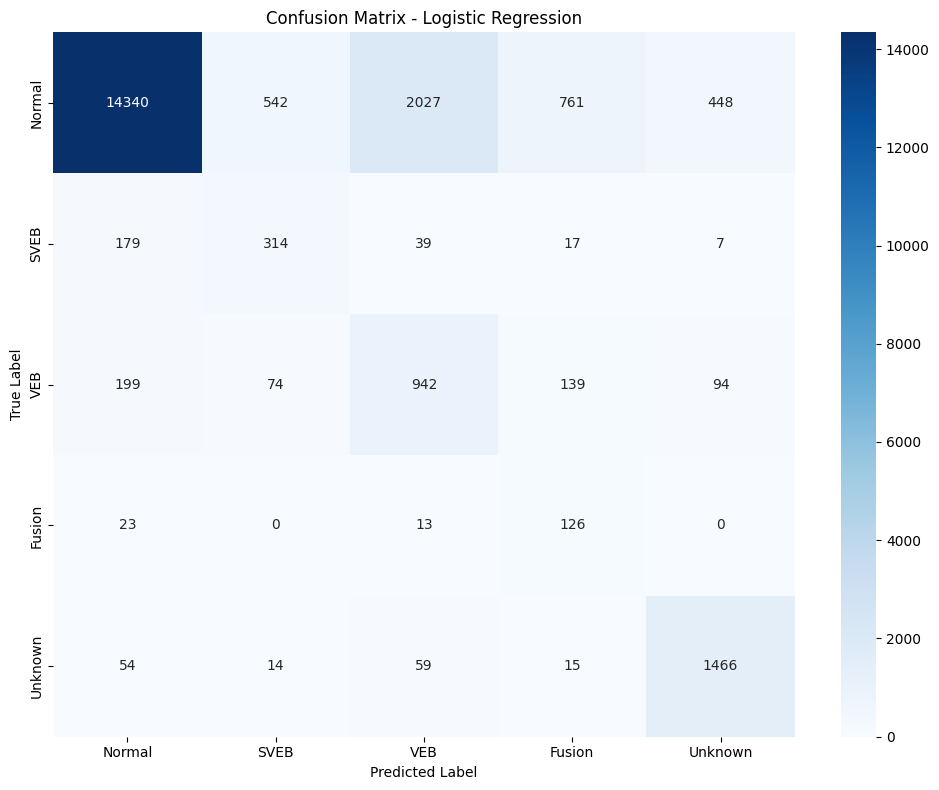


Detailed Classification Report:
              precision    recall  f1-score   support

      Normal     0.9692    0.7915    0.8714     18118
        SVEB     0.3326    0.5647    0.4187       556
         VEB     0.3058    0.6506    0.4161      1448
      Fusion     0.1191    0.7778    0.2066       162
     Unknown     0.7275    0.9117    0.8093      1608

    accuracy                         0.7851     21892
   macro avg     0.4909    0.7392    0.5444     21892
weighted avg     0.8852    0.7851    0.8203     21892



In [5]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns

train = pd.read_csv('/kaggle/input/heartbeat/mitbih_train.csv', header=None)
test = pd.read_csv('/kaggle/input/heartbeat/mitbih_test.csv', header=None)

X_train_full = train.iloc[:, :-1].values
y_train_full = train.iloc[:, -1].values.astype(int)
X_test = test.iloc[:, :-1].values
y_test = test.iloc[:, -1].values.astype(int)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.1, random_state=42, stratify=y_train_full
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("Dataset Summary")
print("=" * 60)
print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Feature dimension: {X_train.shape[1]}")

print("\nModel: Logistic Regression (One-vs-Rest)")
print("Configuration:")
print("  Solver: lbfgs")
print("  Max iterations: 1000")
print("  Regularization: L2 (C=1.0)")
print("  Class weighting: Balanced")

model = LogisticRegression(
    multi_class='ovr',
    solver='lbfgs',
    max_iter=1000,
    C=1.0,
    class_weight='balanced',
    random_state=42
)

print("\nTraining...")
model.fit(X_train_scaled, y_train)

train_acc = model.score(X_train_scaled, y_train)
val_acc = model.score(X_val_scaled, y_val)
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")

print("\n" + "=" * 60)
print("Test Set Evaluation")
print("=" * 60)

y_pred = model.predict(X_test_scaled)
test_acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_acc:.4f}")

print("\nPer-Class Metrics:")
precision, recall, f1, support = precision_recall_fscore_support(
    y_test, y_pred, average=None, labels=[0, 1, 2, 3, 4]
)
class_names = ['Normal', 'SVEB', 'VEB', 'Fusion', 'Unknown']
for i, name in enumerate(class_names):
    print(f"  Class {i} ({name}):")
    print(f"    Precision: {precision[i]:.4f}")
    print(f"    Recall:    {recall[i]:.4f}")
    print(f"    F1-Score:  {f1[i]:.4f}")
    print(f"    Support:   {support[i]}")

print("\nMacro-Averaged Metrics:")
macro_p, macro_r, macro_f1, _ = precision_recall_fscore_support(
    y_test, y_pred, average='macro'
)
print(f"  Precision: {macro_p:.4f}")
print(f"  Recall:    {macro_r:.4f}")
print(f"  F1-Score:  {macro_f1:.4f}")

print("\nWeighted-Averaged Metrics:")
weighted_p, weighted_r, weighted_f1, _ = precision_recall_fscore_support(
    y_test, y_pred, average='weighted'
)
print(f"  Precision: {weighted_p:.4f}")
print(f"  Recall:    {weighted_r:.4f}")
print(f"  F1-Score:  {weighted_f1:.4f}")

cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('Confusion Matrix - Logistic Regression')
plt.tight_layout()
plt.savefig('confusion_matrix_lr.png', dpi=100, bbox_inches='tight')
plt.show()

print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names, digits=4))

## Evaluation